# Fun with Featurtools

In this example [featuretools](https://www.featuretools.com/) a python frame for automated feature engineering is used to generate a wide range of features for machine learning. The aim of the Notebook is to show how the framework is used and how it could support ML workflow, but should not be considered a tutorial on Machine Learning.

One of the main benefits of the framework is the so-called deep feature synthesis (dfs), which used relations in the data for automatically generating features, this could be, obviously depending on your data, features like mean session length, average purchasing price, or standard deviation of time since the last session. The term deep comes refers to stacking generated features on top of each other. 

The main building block of Featuretools is feature primitives and can be represented in two main groups: aggregation and transformation primitive. As the name indicates, aggregation primitives take related inputs and return a single output, similar to group by aggregations known from sql. Transformation primitives, on the other hand, are converting, eg timestamps into data, hours, minutes, seconds, etc, or calculating differences in certain events. The full list of possible primitives can be found [here](https://primitives.featurelabs.com/).


In [96]:
import pandas as pd
import numpy as np
import featuretools as ft
import xgboost as xgb
import warnings

warnings.filterwarnings("ignore")

from featuretools.selection import (
    remove_highly_null_features,
    remove_single_value_features,
)

from woodwork.logical_types import Categorical, Boolean, Datetime, Double
from datetime import datetime
from dateutil.relativedelta import relativedelta
from uuid import uuid4
from functools import reduce


# from scipy.stats import uniform, randint
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# , FunctionTransformer

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.base import BaseEstimator, TransformerMixin
# from typing import List, Any
# from enum import Enum
from dataclasses import dataclass

# pd.option_context("max_columns", None)

As an example we are using the classic Telco Customer Churn dataset which could be found on [Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?select=WA_Fn-UseC_-Telco-Customer-Churn.csv), also the description and column definition could be found there, IBM provide a csv in their Githup repo which could be directly sourced.

In [97]:
URL_TO_DATA = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
BACK_COUNT_DATE = datetime.fromisoformat("2022-01-01")
TEST_SIZE = 0.2
VALID_SIZE = 0.25
RANDOM_STATE = 42
NUMERIC_TRANSFORMER_REPLACEMENT = "median"

In [98]:
def get_cols_by_type(
    in_df: pd.DataFrame, types_to_search: list, exclude_ids: Boolean = True
) -> list:
    """Small helper function selecting columns according to their type."""
    cols = in_df.select_dtypes(include=types_to_search).columns.to_list()

    if exclude_ids:
        return list(filter(lambda x: not x.endswith("ID"), cols))

    return cols

- ft titanic https://www.kaggle.com/code/liananapalkova/automated-feature-engineering-for-titanic-dataset/notebook
- the dataset https://github.com/IBM/telco-customer-churn-on-icp4d/blob/master/data/Telco-Customer-Churn.csv
- titanic https://medium.com/dataexplorations/tool-review-can-featuretools-simplify-the-process-of-feature-engineering-5d165100b0c3
- time indexing recomandations https://stackoverflow.com/questions/49711987/how-do-i-prevent-data-leakage-with-featuretools



In [99]:
# in case of CERTIFICATE_VERIFY_FAILED run Install Certificates.command
# see also https://stackoverflow.com/questions/50236117/scraping-ssl-certificate-verify-failed-error-for-http-en-wikipedia-org
df = pd.read_csv(filepath_or_buffer=URL_TO_DATA, index_col=0)

Since featuretools heavily rely on relations within the data, we split up the dataframe into three entities: Customers, Subscriptions and Billing, and introduce IDs to represent the relationship between them. 

- customer_df: customer_id (PK), subscription_id (FK), billing_id (FK), gender, SeniorCitizen, Partner, Dependents, tenure, Churn
- services_df: service_id (PK), service_name
- subscription_df: subscription_id (PK), service_id, customer_id
- billing_df: billing_id (PK), Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges

PK indicating primary keys and FK foreign keys. 


In [100]:
# mapping between column names and featuretools data types.
CUSTOMERS = {
    "gender": Boolean,
    "SeniorCitizen": Boolean,
    "Partner": Boolean,
    "Dependents": Boolean,
}


SUBSCRIPTIONS = {
    "PhoneService": Categorical,
    "MultipleLines": Boolean,
    "InternetService": Categorical,
    "OnlineSecurity": Categorical,
    "OnlineBackup": Categorical,
    "DeviceProtection": Categorical,
    "TechSupport": Categorical,
    "StreamingTV": Categorical,
    "StreamingMovies": Categorical,
}


BILLINGS = {
    "tenure": Double,
    "Contract": Categorical,
    "PaperlessBilling": Boolean,
    "PaymentMethod": Categorical,
    "MonthlyCharges": Double,
    "TotalCharges": Double,
}


@dataclass
class EntitySetColumns:
    """Small helper class for organizing dataframes and columns."""

    new_dataframe_name: str
    index: str
    additional_columns: list


entity_set_columns = {
    "customers": EntitySetColumns(
        index="customerID",
        new_dataframe_name=None,
        additional_columns=list(CUSTOMERS.keys()),
    ),
    "subscriptions": EntitySetColumns(
        index="subscriptionID",
        new_dataframe_name="subscriptions",
        additional_columns=list(SUBSCRIPTIONS.keys()),
    ),
    "billings": EntitySetColumns(
        index="billingID",
        new_dataframe_name="billings",
        additional_columns=list(BILLINGS.keys()),
    ),
}

# adding PK's to the data
df["customerID"] = df.index
df["billingID"] = [str(uuid4()) for _ in range(df.shape[0])]
df["subscriptionID"] = [str(uuid4()) for _ in range(df.shape[0])]

Further we need to clean the data a bit:

In [101]:
# convert total charges to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# generate syntetic time index
df["ContractStartDate"] = list(
    map(
        lambda tenure, dat=BACK_COUNT_DATE: dat - relativedelta(months=-tenure),
        df["tenure"],
    )
)

# convert to 1/0
df["Churn"] = np.where(df["Churn"] == "Yes", 1, 0)

Since not some features require domain knowledge, not all features could be generated automatically, for example, categorize the length of a contract or how many products the user subscribed to, which could not be determined automatically in our example.

In [102]:
# adding more features
df["ShortContract"] = df["Contract"] == "Month-to-month"
BILLINGS["ShortContract"] = Boolean

# remove because it depends on Phone service
products = [n for n in list(SUBSCRIPTIONS.keys()) if n != "MultipleLines"]
df["TotalProductCount"] = (df[products] != "No").sum(axis=1)
SUBSCRIPTIONS["TotalProductCount"] = Double

df["UserCategory"] = pd.cut(
    x=df["TotalProductCount"], bins=[0, 3, 6, np.Inf], labels=["light", "mid", "heavy"]
)
CUSTOMERS["UserCategory"] = Categorical

In [103]:
y = df["Churn"]
X = df.drop(columns=["Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALID_SIZE, random_state=RANDOM_STATE
)  # 0.25 x 0.8 = 0.2

For representing data frames and their relations, featuretools useses entity sets. In our case, we represent the data in a parent-child relation, where the customer dataframe is the parent and billings and subscriptions are the children. By providing our primary keys as an index and having foreign keys present in the parent dataframe, the framework could set up the relations. 

In [104]:
def entityset_wrapper(
    id: str,
    data_frame_name: str,
    feature_dataset: pd.DataFrame,
    variable_types: dict,
    entity_set_columns: dict,
) -> ft.EntitySet:
    """Non generic wrapper for making ft.EntitySet"""
    es = ft.EntitySet(id=id)

    es.add_dataframe(
        dataframe_name=data_frame_name,
        index=entity_set_columns.get("customers").index,
        logical_types=variable_types,
        dataframe=feature_dataset,
    )

    es.normalize_dataframe(
        base_dataframe_name=data_frame_name,
        new_dataframe_name=entity_set_columns.get("billings").new_dataframe_name,
        index=entity_set_columns.get("billings").index,
        additional_columns=entity_set_columns.get("billings").additional_columns,
    )

    es.normalize_dataframe(
        base_dataframe_name=data_frame_name,
        new_dataframe_name=entity_set_columns.get("subscriptions").new_dataframe_name,
        index=entity_set_columns.get("subscriptions").index,
        additional_columns=entity_set_columns.get("subscriptions").additional_columns,
    )

    return es

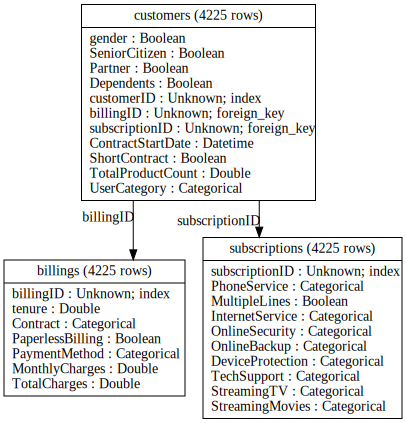

In [105]:
es = entityset_wrapper(
    id="customers_train",
    data_frame_name="customers",
    feature_dataset=X_train,
    variable_types=CUSTOMERS | SUBSCRIPTIONS | BILLINGS,
    entity_set_columns=entity_set_columns,
)
es.plot()

With the entity set in place, we can call the deep feature synthesis function to finally generate the features. For details on how the algorithm works, please refer to the paper of [Kanter and Veeramachaneni: Deep Feature Synthesis:
Towards Automating Data Science Endeavors](https://dai.lids.mit.edu/wp-content/uploads/2017/10/DSAA_DSM_2015.pdf).

In [106]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="customers",
    max_depth=4,
    include_cutoff_time=False,
)

feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_defs)
print(f"Shape of the resulting feature matrix {feature_matrix_enc.shape}")

Shape of the resulting feature matrix (4225, 184)


Note that the `max_depth` regulates the depth the generation step takes place, eg depth one only existing features are used as input. Depth two takes the generated features from depth one and replays the algorithm to the results from depth one. 

The resulting feature encoded matrix contains 118 columns. After feature generation it's common to remove space features and features which do not contain a lot of information, to decrease the risk of overfitting and improve accuracy. In this example, we use two approaches to address the problem, first the build-in functions `remove_highly_null_features` and `remove_single_value_features` from feature tools and also a variance threshold (`VarianceThreshold`) method from sklearn. 

In [107]:
PCT_NULL_THRESHOLD = 0.85

fm_wo_high_null, f_wo_high_null = remove_highly_null_features(
    feature_matrix_enc, features=features_enc, pct_null_threshold=PCT_NULL_THRESHOLD
)
print(f"Number of removed features: {len(set(features_enc) - set(f_wo_high_null))}")

fm_wo_sv, f_wo_sv = remove_single_value_features(
    fm_wo_high_null, features=f_wo_high_null
)
print(f"Number of removed features: {len(set(f_wo_sv) - set(f_wo_high_null))}")

X_train_feature_matrix = fm_wo_sv
X_train_features = f_wo_sv

X_train_feature_matrix.shape

Number of removed features: 4
Number of removed features: 0


(4225, 132)

As the name indicates, `remove_highly_null_features ` removes all columns where the null share is above the threshold, in our case above 85%, in total four columns got removed. Additionally, we checked `remove_single_value_features ` which removes columns where all values are the same, but no additional column (of the remaining once) got removed.

Column removal based on low variance is part of the sklearn pipeline, therefore will be done later. Other steps include NA replacements via `SimpleImputer` and scaling via `StandardScaler`, both steps are applied for all numeric features. 

In [108]:
# fmt: off
numeric_features_ft = get_cols_by_type(
    in_df=X_train_feature_matrix,
    types_to_search=[np.float64, np.int64],
    exclude_ids=False,
)

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.nan, strategy=NUMERIC_TRANSFORMER_REPLACEMENT)),
        ("scaler", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features_ft),
    ], verbose=True, remainder = "passthrough"
)
# fmt: on
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['TotalProductCount', 'billings.tenure',
                                  'billings.MonthlyCharges',
                                  'billings.TotalCharges',
                                  'billings.MAX(customers.TotalProductCount)',
                                  'billings.MEAN(customers.TotalProductCount)',
                                  'billings.MIN(cust...
                                  'billings.SUM(customers.TotalProductCount)',
                                  'subscriptions.MAX(customers.TotalProductCount)',
                                  'subscriptions.MEAN(customers.TotalProductCount)',
                                  'subscriptions.MIN(customers.TotalProductCount)',
                                  'subscriptions.PERCENT_TRUE(customers.SeniorCitizen)',
                                  'subscriptions.PERCENT_TRUE(customers.ShortContract)',
                                  'subscriptions.SUM(customers.TotalProductCount)'])],
                  verbose=True)

As mentioned at the beginning, the notebook mainly focuses on featertools, but to finish the task we are also gonna fit a Support Vector Machine classifier [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) classifier. All the hyperparameter tuning, model selection, and how to improve prediction accuracy will be part of other notebooks. Therefore we mainly use the default settings here. 

In [145]:
# VARIANCE_THRESHOLD = 0.8 * (1 - 0.8)
MAX_ITER = 10**4
LEARNING_RATE = 0.35

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# fmt: off
clf = Pipeline(
    steps=[ ("preprocessor",            preprocessor), 
            #('feature_selection_var',   VarianceThreshold(threshold=VARIANCE_THRESHOLD)),
            #("classifier",              xgb.XGBClassifier(objective="binary:logistic", learning_rate=LEARNING_RATE, random_state=RANDOM_STATE))],
           # ("classifier",              RandomForestClassifier())
            #("classifier",                LogisticRegression())
            ("classifier",                svm.SVC(kernel='rbf'))
            #],
            verbose=True
            
)
# fmt: on

clf.fit(X_train_feature_matrix, y_train)

[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.9s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['TotalProductCount',
                                                   'billings.tenure',
                                                   'billings.MonthlyCharges',
                                                   'billings.TotalCharges',
                                                   'billings.MAX(customers.TotalProductCount)',
                                                   'billings.MEAN(customers.TotalP...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.35, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=42, reg_alpha=0,
                               reg_lambda=1, ...))],
         verbose=True)

Since we need to keep training, test, and validation data separate, we must also apply all transformations done by feature tools to the test and validation datasets. Therefore we again create an entity set and together with the feature definitions from the training set we can generate the same features for the other datasets. 

As the last step, we only have to call our pipeline for the transformed test and validation dataset. 

In [146]:
es_val = entityset_wrapper(
    id="customers_validation",
    data_frame_name="customers",
    feature_dataset=X_val,
    variable_types=CUSTOMERS | SUBSCRIPTIONS | BILLINGS,
    entity_set_columns=entity_set_columns,
)

val_transformed = ft.calculate_feature_matrix(X_train_features, es_val)


es_test = entityset_wrapper(
    id="customers_test",
    data_frame_name="customers",
    feature_dataset=X_test,
    variable_types=CUSTOMERS | SUBSCRIPTIONS | BILLINGS,
    entity_set_columns=entity_set_columns,
)

test_transformed = ft.calculate_feature_matrix(X_train_features, es_test)


print("model score: %.4f" % clf.score(val_transformed, y_val))
print("model score: %.4f" % clf.score(test_transformed, y_test))

model score: 0.7850
model score: 0.7892


## Benchmarking

As the last step, we gonna experiment with different depths of the features and what's happening to the model performance when we don't use feature selection algorithms.

In [147]:
@dataclass
class BenchmarkData:
    es: ft.EntitySet
    X: pd.DataFrame
    y: pd.Series


def _wrap_col_transformer(feature_matrix: pd.DataFrame) -> ColumnTransformer:
    numeric_ft = get_cols_by_type(
        in_df=feature_matrix,
        types_to_search=[np.float64, np.int64],
        exclude_ids=False,
    )

    numeric_transformer = Pipeline(
        steps=[
            (
                "imputer",
                SimpleImputer(
                    missing_values=np.nan, strategy=NUMERIC_TRANSFORMER_REPLACEMENT
                ),
            ),
            ("scaler", StandardScaler()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_ft),
        ],
        verbose=True,
        remainder="passthrough",
    )
    # fmt: on
    return preprocessor


def benchmark(
    train_data: BenchmarkData,
    test_data: BenchmarkData,
    val_data: BenchmarkData,
    ft_selection_functions: tuple,
    fitting_pipe: Pipeline,
    target_df_name: str = None,
    max_depth: int = 2,
    **kwargs_dfs,
) -> dict:

    ft_matrix = ft.dfs(
        entityset=train_data.es,
        target_dataframe_name=target_df_name,
        max_depth=max_depth,
        include_cutoff_time=False,
        **kwargs_dfs,
    )

    ft_matrix_enc = ft.encode_features(*ft_matrix)
    ft_matrix_reduced = (
        ft_matrix_enc
        if ft_selection_functions is None
        else reduce(lambda res, f: f(*res), ft_selection_functions, ft_matrix_enc)
    )
    # ft_matrix_reduced  = reduce(lambda res, f: f(*res), ft_selection_functions, ft_matrix_enc)
    print(f"Feature Matrix shape with {max_depth}: {ft_matrix_reduced[0].shape}")
    val_tf = ft.calculate_feature_matrix(ft_matrix_reduced[1], val_data.es)
    test_tf = ft.calculate_feature_matrix(ft_matrix_reduced[1], test_data.es)
    train_tf = ft_matrix_reduced[0]

    col_transformer_new = _wrap_col_transformer(train_tf)
    fitting_pipe.steps.pop(0)  # remove preprocessor step
    fitting_pipe.steps.insert(
        0, ("preprocessor", col_transformer_new)
    )  # insert new preprocessor step
    fitting_pipe.fit(X=train_tf, y=train_data.y)

    return {
        "model_score_validation": fitting_pipe.score(val_tf, val_data.y),
        "model_score_test": fitting_pipe.score(test_tf, test_data.y),
    }

In [148]:
train_data = BenchmarkData(es=es, X=X_train, y=y_train)
test_data = BenchmarkData(es=es_test, X=X_test, y=y_test)
val_data = BenchmarkData(es=es_val, X=X_val, y=y_val)

In [149]:
result_dic = dict()

with_f_select = {
    'train_data':train_data, 
    'test_data':test_data, 
    'val_data':val_data, 
    'ft_selection_functions':(remove_highly_null_features,remove_single_value_features),
    'target_df_name':"customers",
    'fitting_pipe':clf,
    'max_depth':None
    }

without_f_select = dict(with_f_select)
without_f_select['ft_selection_functions'] = None



for i in [1,2,3]:
    with_f_select['max_depth'] = i
    without_f_select['max_depth'] = i
    
    result_dic[f'max_depth_{i}_with_feature_selection'] = benchmark(**with_f_select)
    result_dic[f'max_depth_{i}_without_feature_selection'] = benchmark(**without_f_select)




Feature Matrix shape with 1: (4225, 64)
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.4s
Feature Matrix shape with 1: (4225, 84)
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.5s
Feature Matrix shape with 2: (4225, 82)
[ColumnTransformer] ........... (1 of 2) Processing num, total=   0.0s
[ColumnTransformer] ..... (2 of 2) Processing remainder, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   0.5s
Feature Matrix shape with 2:

In [150]:
results_df = pd.DataFrame(result_dic).transpose()
results_df['diff'] = results_df.model_score_test - results_df.model_score_validation
results_df


,model_score_validation,model_score_test,diff
max_depth_1_with_feature_selection,0.784954,0.789212,0.004258
max_depth_1_without_feature_selection,0.784954,0.789212,0.004258
max_depth_2_with_feature_selection,0.784954,0.789212,0.004258
max_depth_2_without_feature_selection,0.784954,0.789212,0.004258
max_depth_3_with_feature_selection,0.784954,0.789212,0.004258
max_depth_3_without_feature_selection,0.784954,0.789212,0.004258
